## Инициализация 

In [1]:
# Исправленный и оптимизированный pipeline
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier, Pool
from catboost.utils import get_gpu_device_count
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import LabelEncoder
import gc
import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 255
np.random.seed(RANDOM_STATE)

# Global variables

col_drop = ['id', 'ItemID', 'SellerID']
target = 'resolution'
hard_threshold_low = 0.2
hard_threshold_high = 0.8
stage_name = ''
global confident_df 
confident_df = pl.DataFrame()
# Storage for models, features, and used feature names
models = {}
features = {}
used_features_across_stages = set()  # Отслеживание использованных признаков
final_predictions = {}
label_encoders = {}
all_predictions = {}

def check_memory_usage():
    import psutil
    import os
    process = psutil.Process(os.getpid())
    memory_gb = process.memory_info().rss / (1024 * 1024 * 1024)
    print(f"Memory: {memory_gb:.2f} GB")
    if memory_gb > 6:  # 6GB limit
        print("Memory warning!")
    return memory_gb

### Удаление дублирующихся признаков (при выборе наилучших признаков) 

In [2]:
def remove_duplicate_features(df: pd.DataFrame, stage_name: str) -> pd.DataFrame:
    """Удаляет полностью дублирующие и высококоррелированные признаки из Pandas DataFrame"""
    print(f"Removing duplicates for {stage_name}...")

    feature_cols = [col for col in df.columns if col not in col_drop + [target]]

    if len(feature_cols) < 2:
        return df

    duplicates_to_remove = set()

    # 1. Проверяем полные дубликаты колонок
    cols = df[feature_cols].columns
    for i in range(len(cols)):
        for j in range(i + 1, len(cols)):
            col1, col2 = cols[i], cols[j]
            if col1 not in duplicates_to_remove and col2 not in duplicates_to_remove:
                if df[col1].equals(df[col2]):
                    duplicates_to_remove.add(col2)
                    print(f"Removed identical: {col2} (same as {col1})")

    # 2. Проверяем корреляцию по числовым колонкам и удаляем при corr > 0.95
    remaining_cols = [c for c in feature_cols if c not in duplicates_to_remove]
    numeric_cols = df[remaining_cols].select_dtypes(include=np.number).columns.tolist()

    if len(numeric_cols) > 1:
        corr_matrix = df[numeric_cols].corr().abs()  # абсолютные значения корреляции

        # Матрица корреляций симметрична, смотрим только верхний треугольник
        upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

        for col in upper_tri.columns:
            high_corrs = upper_tri[col][upper_tri[col] > 0.95].index.tolist()
            for drop_col in high_corrs:
                if drop_col not in duplicates_to_remove:
                    duplicates_to_remove.add(drop_col)
                    print(f"Removed highly correlated: {drop_col} (corr > 0.95 with {col})")

    if duplicates_to_remove:
        df = df.drop(columns=list(duplicates_to_remove))
        print(f"Removed total {len(duplicates_to_remove)} duplicate/highly correlated features")

    return df

### Функции визализации

In [3]:
def plot_feature_importance(model, feature_names, stage_name, top_n=10):
    """Визуализация топ-N важных признаков для модели CatBoost"""
    try:
        feature_importance = model.get_feature_importance()
        
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': feature_importance
        }).sort_values('importance', ascending=False).head(top_n)
        
        plt.figure(figsize=(12, 8))
        bars = plt.barh(range(len(importance_df)), importance_df['importance'], 
                       color='skyblue', alpha=0.8, edgecolor='navy', linewidth=0.5)
        
        plt.yticks(range(len(importance_df)), importance_df['feature'])
        plt.xlabel('Feature Importance', fontsize=12, fontweight='bold')
        plt.ylabel('Features', fontsize=12, fontweight='bold')
        plt.title(f'Top {top_n} Feature Importance - Stage: {stage_name.upper()}', 
                 fontsize=14, fontweight='bold', pad=20)
        
        # Добавляем значения важности на бары
        for i, (bar, importance) in enumerate(zip(bars, importance_df['importance'])):
            plt.text(importance + max(importance_df['importance']) * 0.01, 
                    bar.get_y() + bar.get_height()/2, 
                    f'{importance:.2f}', 
                    va='center', fontsize=10, fontweight='bold')
        
        plt.gca().invert_yaxis()
        plt.grid(axis='x', alpha=0.3, linestyle='--')
        plt.tight_layout()
        plt.show()
        
        print(f"\\n=== TOP {top_n} FEATURES FOR STAGE {stage_name.upper()} ===")
        for idx, row in importance_df.iterrows():
            print(f"{importance_df.index.get_loc(idx)+1:2d}. {row['feature']:<40} {row['importance']:>8.4f}")
        print("=" * 60)
        
        return importance_df
        
    except Exception as e:
        print(f"Error plotting feature importance for {stage_name}: {e}")
        return pd.DataFrame()

def plot_confusion_matrix_train(model, X_train, y_train, stage_name):
    """Построение confusion matrix для тренировочных данных"""
    try:
        y_pred_train = model.predict(X_train)
        y_pred_proba_train = model.predict_proba(X_train)[:, 1]
        
        cm = confusion_matrix(y_train, y_pred_train)
        f1 = f1_score(y_train, y_pred_train)
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
        
        plt.title(f'Confusion Matrix - Stage: {stage_name.upper()}\n'
                 f'F1-Score: {f1:.4f} | Samples: {len(y_train)}', 
                 fontsize=14, fontweight='bold', pad=20)
        plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
        plt.ylabel('True Label', fontsize=12, fontweight='bold')
        
        plt.xticks([0.5, 1.5], ['Class 0', 'Class 1'])
        plt.yticks([0.5, 1.5], ['Class 0', 'Class 1'])
        
        plt.tight_layout()
        plt.show()
        
        print(f"\\n=== CONFUSION MATRIX ANALYSIS - STAGE {stage_name.upper()} ===")
        print(f"Total samples: {len(y_train)}")
        print(f"True Negatives (TN): {cm[0,0]}")
        print(f"False Positives (FP): {cm[0,1]}")
        print(f"False Negatives (FN): {cm[1,0]}")
        print(f"True Positives (TP): {cm[1,1]}")
        
        precision = cm[1,1] / (cm[1,1] + cm[0,1]) if (cm[1,1] + cm[0,1]) > 0 else 0
        recall = cm[1,1] / (cm[1,1] + cm[1,0]) if (cm[1,1] + cm[1,0]) > 0 else 0
        accuracy = (cm[0,0] + cm[1,1]) / cm.sum()
        
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-Score: {f1:.4f}")
        print(f"Accuracy: {accuracy:.4f}")
        print("=" * 60)
        
        return cm, f1, precision, recall, accuracy
        
    except Exception as e:
        print(f"Error plotting confusion matrix for {stage_name}: {e}")
        return None, 0, 0, 0, 0

def plot_prediction_distribution(model, X_train, y_train, stage_name):
    """Визуализация распределения вероятностей предсказаний"""
    try:
        y_pred_proba = model.predict_proba(X_train)[:, 1]
        
        plt.figure(figsize=(12, 6))
        
        plt.hist(y_pred_proba[y_train == 0], bins=50, alpha=0.7, 
                label='Class 0 (Negative)', color='lightcoral', density=True)
        plt.hist(y_pred_proba[y_train == 1], bins=50, alpha=0.7, 
                label='Class 1 (Positive)', color='skyblue', density=True)
        
        plt.axvline(x=0.5, color='red', linestyle='--', linewidth=2, 
                   label='Decision Threshold (0.5)')
        
        if stage_name == 'hard':
            plt.axvline(x=hard_threshold_low, color='orange', linestyle='--', 
                       label=f'Hard Low ({hard_threshold_low})')
            plt.axvline(x=hard_threshold_high, color='green', linestyle='--', 
                       label=f'Hard High ({hard_threshold_high})')
        
        plt.xlabel('Prediction Probability', fontsize=12, fontweight='bold')
        plt.ylabel('Density', fontsize=12, fontweight='bold')
        plt.title(f'Prediction Probability Distribution - Stage: {stage_name.upper()}', 
                 fontsize=14, fontweight='bold', pad=20)
        plt.legend()
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error plotting prediction distribution for {stage_name}: {e}")

def plot_final_pipeline_summary(models, features):
    """Финальная сводка по всем стадиям pipeline"""
    print("\\n" + "="*80)
    print("FINAL PIPELINE SUMMARY")
    print("="*80)
    
    summary_data = []
    for stage_name, model in models.items():
        if model is not None:
            stage_features = features[stage_name]
            feature_count = len(stage_features)
            
            try:
                best_score = model.best_score_['validation']['F1']
            except:
                best_score = "N/A"
            
            summary_data.append({
                'Stage': stage_name.upper(),
                'Features': feature_count,
                'Best F1': best_score,
                'Iterations': model.tree_count_ if hasattr(model, 'tree_count_') else "N/A"
            })
    
    summary_df = pd.DataFrame(summary_data)
    print(summary_df.to_string(index=False))
    print("="*80)
    
    return summary_df

def plot_final_confusion_matrix(models, features, df, target='resolution'):
    """
    Рисует итоговую confusion matrix объединенной модели pipeline на полном наборе
    
    models: dict со всеми моделями стадий (hard, soft, error)
    features: dict со списками признаков каждой стадии
    df: DataFrame с полными данными для предсказания
    """
    # Здесь можно объединить предсказания всех моделей через каскад
    # или взять лучшую модель, в зависимости от логики
    
    # Для примера берем модель hard (или измените на нужную)
    model = models.get('hard')
    if model is None:
        print("No 'hard' stage model found")
        return
    
    feat = features.get('hard')
    if feat is None:
        print("No features for 'hard' stage")
        return
    
    X = df[feat].copy()
    y = df[target]
    
    # Убедитесь, что все заполнено
    X = X.fillna(0)
    
    y_pred = model.predict(X)
    
    cm = confusion_matrix(y, y_pred)
    
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Final Confusion Matrix on Full Data')
    plt.show()
    
    print("Confusion Matrix:\n", cm)

## Генерация новых признаков

In [4]:
def advanced_feature_engineering(df, stage, text_columns, used_features_global):
    """Оптимизированная генерация признаков без повторений между стадиями"""
    print(f"Feature engineering{stage}...")
    
    # Определяем числовые колонки
    numeric_cols = []
    for col, dtype in df.schema.items():
        if col not in col_drop + [target] + text_columns:
            if dtype in [pl.Int8, pl.Int16, pl.Int32, pl.Int64, pl.Float32, pl.Float64]:
                numeric_cols.append(col)
    
    # Разделяем на continuous и categorical
    continuous_cols = []
    categorical_cols = []
    
    for col in numeric_cols:
        if col in df.columns:
            unique_count = df[col].n_unique()
            if unique_count > 50:
                continuous_cols.append(col)
            else:
                categorical_cols.append(col)
    
    print(f"Continuous: {len(continuous_cols)}, Categorical: {len(categorical_cols)}")
    
    expressions = []
    new_feature_names = set()
    
    # 1. Трансформации непрерывных признаков (с проверкой на повторения)
    for col in continuous_cols[:10]:  # Ограничиваем до 10 для экономии ресурсов
        if col in df.columns:
            # Создаем уникальные имена признаков для этой стадии
            log_name = f"{col}_log_{stage}"
            sqrt_name = f"{col}_sqrt_{stage}"
            sq_name = f"{col}_sq_{stage}"
            inv_name = f"{col}_inv_{stage}"
            
            # Проверяем, не использовались ли эти признаки раньше
            stage_features = {log_name, sqrt_name, sq_name, inv_name}
            if not (stage_features & used_features_global):  # Если пересечения нет
                expressions.extend([
                    pl.when(pl.col(col) > 0).then(pl.col(col).log()).otherwise(0).alias(log_name),
                    pl.when(pl.col(col) >= 0).then(pl.col(col).sqrt()).otherwise(0).alias(sqrt_name),
                    (pl.col(col) ** 2).alias(sq_name),
                    pl.when(pl.col(col) != 0).then(1.0 / pl.col(col)).otherwise(0).alias(inv_name)
                ])
                new_feature_names.update(stage_features)
    
    # 2. Парные комбинации (очень ограниченные для экономии ресурсов)
    if len(continuous_cols) >= 2:
        top_continuous = continuous_cols[:10]  # Берем только топ-4 признака
        for i in range(len(top_continuous)):
            for j in range(i+1, len(top_continuous)):
                col1, col2 = top_continuous[i], top_continuous[j]
                if col1 in df.columns and col2 in df.columns:
                    # Уникальные имена для стадии
                    ratio_name = f"{col1}_{col2}_ratio_{stage}"
                    prod_name = f"{col1}_{col2}_prod_{stage}"
                    diff_name = f"{col1}_{col2}_diff_{stage}"
                    
                    stage_features = {ratio_name, prod_name, diff_name}
                    if not (stage_features & used_features_global):
                        expressions.extend([
                            pl.when(pl.col(col2) != 0).then(pl.col(col1) / pl.col(col2)).otherwise(0).alias(ratio_name),
                            (pl.col(col1) * pl.col(col2)).alias(prod_name),
                            (pl.col(col1) - pl.col(col2)).alias(diff_name)
                        ])
                        new_feature_names.update(stage_features)
    
    # 3. Percentile-based features (ограниченно)
    for col in continuous_cols[:10]:  # Только для 5 топовых признаков
        if col in df.columns:
            try:
                q75 = df[col].quantile(0.75)
                q25 = df[col].quantile(0.25)
                median = df[col].median()
                
                q75_name = f"{col}_q75flag_{stage}"
                q25_name = f"{col}_q25flag_{stage}"
                median_name = f"{col}_medianlag_{stage}"
                
                stage_features = {q75_name, q25_name, median_name}
                if not (stage_features & used_features_global):
                    expressions.extend([
                        (pl.col(col) > q75).cast(pl.Int8).alias(q75_name),
                        (pl.col(col) < q25).cast(pl.Int8).alias(q25_name),
                        (pl.col(col) > median).cast(pl.Int8).alias(median_name)
                    ])
                    new_feature_names.update(stage_features)
            except:
                pass
    
    # Применяем expressions батчами
    if expressions:
        batch_size = 25  # Уменьшенный размер батча
        print(f"Applying {len(expressions)} expressions in batches of {batch_size}")
        
        for i in range(0, len(expressions), batch_size):
            end = min(i + batch_size, len(expressions))
            batch = expressions[i:end]
            try:
                df = df.with_columns(batch)
            except Exception as e:
                print(f"Error in batch {i}: {e}")
                continue
            del batch
            gc.collect()
            
            # Проверка памяти
            if check_memory_usage() > 6:  # Если больше 5GB
                print("Memory limit reached, stopping feature generation")
                break
    
    # Обновляем глобальный набор использованных признаков
    used_features_global.update(new_feature_names)
    
    print(f"Generated {len(expressions)} new features for {stage}")
    
    del expressions
    gc.collect()
    df_p = df.to_pandas()
    # Удаляем дублирующиеся признаки
    df = remove_duplicate_features(df_p, stage).copy()
    
    return df

## Отбор лучших признаков

In [5]:
def improved_feature_selection(df_pan, stage, max_features, text_columns):
    """Оптимизированный отбор признаков"""
    print(f"Feature selection {stage} (max {max_features})...")
    
    feature_cols = [col for col in df_pan.columns if col not in col_drop + [target]]
    if len(feature_cols) < 2:
        return pd.DataFrame(), []
    
    working_data = df_pan.copy()
    
    # Разделяем на числовые и текстовые
    numeric_features = []
    text_features = []
    batch_size = 15  # Уменьшенный размер батча для экономии ресурсов
    
    for col in feature_cols:
        if col in text_columns:
            text_features.append(col)
            working_data[col] = working_data[col].fillna('missing')
        else:
            try:
                working_data[col] = pd.to_numeric(working_data[col], errors='raise')
                numeric_features.append(col)
            except (ValueError, TypeError):
                if col not in label_encoders and working_data[col].nunique() < 20:
                    label_encoders[col] = LabelEncoder()
                    working_data[col] = label_encoders[col].fit_transform(
                        working_data[col].fillna('missing')
                    )
                    numeric_features.append(col)
                elif working_data[col].nunique() < 20:
                    working_data[col] = label_encoders[col].transform(
                        working_data[col].fillna('missing')
                    )
                    numeric_features.append(col)
    
    selected_features = []
    
    
    # Отбор числовых признаков
    if numeric_features:
        y = working_data[target].copy()
        
        # Обработка target
        if y.isnull().any():
            print("Warning: NaN in target. Filling with median.")
            y = y.fillna(y.median())
        
        mi_scores = np.zeros(len(numeric_features))
        
        # Обработка батчами с уменьшенным размером
        for start in range(0, len(numeric_features), batch_size):
            gc.collect()
            end = min(start + batch_size, len(numeric_features))
            batch_features = numeric_features[start:end]
            X_batch = working_data[batch_features].copy()
            
            # Очистка данных
            X_batch = X_batch.fillna(0)
            X_batch = X_batch.replace([np.inf, -np.inf], 1e10)
            
            # Проверка на NaN и Inf
            if np.any(np.isnan(X_batch)) or np.any(np.isinf(X_batch)):
                print(f"Batch {start}-{end} has NaN or Inf. Skipping.")
                mi_scores[start:end] = 0
                continue
            
            try:
                # Используем n_jobs=1 для стабильности
                mi_batch = mutual_info_classif(X_batch, y, random_state=RANDOM_STATE, n_jobs=1)
                mi_scores[start:end] = mi_batch
                print(f"Processed batch {start}-{end}")
            except Exception as e:
                print(f"MI calculation failed on batch {start}-{end}: {e}")
                # Используем корреляцию как fallback
                try:
                    corr_with_target = X_batch.corrwith(y).abs()
                    for i, col_name in enumerate(batch_features):
                        corr_val = corr_with_target[col_name]
                        if np.isnan(corr_val):
                            mi_scores[start + i] = 0
                        else:
                            mi_scores[start + i] = corr_val
                except Exception as corr_e:
                    print(f"Correlation calculation also failed: {corr_e}")
                    for i in range(len(batch_features)):
                        mi_scores[start + i] = 0
        
        # Отбор лучших признаков
        valid_indices = ~np.isnan(mi_scores) & (mi_scores > 0)
        if np.sum(valid_indices) > 0:
            valid_scores = mi_scores[valid_indices]
            valid_features = [numeric_features[i] for i in range(len(numeric_features)) if valid_indices[i]]
            
            # Берем топ признаков
            n_select = min(max_features - 5, len(valid_features))  # Оставляем место для текстовых
            top_indices = np.argsort(valid_scores)[-n_select:]
            selected_features = [valid_features[i] for i in top_indices]
        else:
            selected_features = numeric_features[:max_features - 5]
    
    # Добавляем текстовые признаки (только для non-hard стадий)
    if stage.lower() != 'hard' and text_features:
        selected_features.extend(text_features[:min(5, len(text_features))])
    
    # Ограничиваем итоговое количество
    result_features = selected_features[:max_features]
    
    if result_features:
        result_data = working_data[result_features + [target]].copy()
    else:
        result_data = pd.DataFrame()
    
    print(f"Selected {len(result_features)} features")
    
    del working_data, X_batch
    gc.collect()
    
    return result_data, result_features

## Обучение стадии с отслеживанием использованных признаков

In [6]:
def train_stage(df, stage_name, max_features, text_columns, used_features_global):
    """Обучение стадии с отслеживанием использованных признаков"""
    print("="*60)
    print(f"STAGE: {stage_name.upper()}")
    print("="*60)
    print(f"Sample size: {len(df)}")
    
    try:
        # Feature engineering с отслеживанием использованных признаков
        df_pandas = advanced_feature_engineering(df, stage_name, text_columns, used_features_global)
        #df_pandas = df_processed.to_pandas()
        
        # Feature selection
        result_data, selected_features = improved_feature_selection(
            df_pandas, stage_name, max_features, text_columns)
        
        
        if len(selected_features) == 0:
            print(f"No features selected for {stage_name}!")
            return None, None, None
        
        # Подготовка данных для CatBoost
        X_train = result_data[selected_features].copy()
        y = result_data[target].copy()
        
        # Обработка целевой переменной
        unique_y = y.unique()
        if len(unique_y) != 2 or not all(val in [0, 1] for val in unique_y):
            print(f"Invalid target values: {unique_y}")
            y = y.astype(int)
        
        print(f"Features selected: {len(selected_features)}")
        
        # Определение категориальных и текстовых признаков
        cat_features_idx = []
        text_features_idx = []
        
        for i, col in enumerate(selected_features):
            if col in text_columns:
                text_features_idx.append(i)
                X_train[col] = X_train[col].astype(str).fillna('missing')
            elif (X_train[col].dtype == 'object' or 
                  (X_train[col].nunique() < 50 and 
                   not pd.api.types.is_numeric_dtype(X_train[col]))):
                cat_features_idx.append(i)
                X_train[col] = X_train[col].fillna('missing')
        
        print(f"Categorical features: {len(cat_features_idx)}, Text features: {len(text_features_idx)}")
        
        # Для hard стадии убираем текстовые признаки
        if stage_name == 'hard':
            text_features_idx = []
            print("Hard stage: removing text features")
        
        # Создание Pool
        train_pool = Pool(
            X_train,
            y,
            cat_features=cat_features_idx,
            text_features=text_features_idx
        )
        check_memory_usage()
        # Параметры модели в зависимости от стадии
        base_catboost_params = {
            'random_seed': RANDOM_STATE,
            'task_type': 'GPU',  # Изменено на CPU для стабильности
            'verbose': False,
            'eval_metric': 'F1',
            'custom_metric': 'Recall',
            'loss_function': 'Logloss',
            'use_best_model': True,
            'early_stopping_rounds': 20,
            'thread_count': 2,  # Ограничиваем количество потоков
            'allow_writing_files': False
        }
        
        stage_params = base_catboost_params.copy()
        if stage_name == 'hard':
            stage_params.update({
                'iterations': 200,
                'depth': 6,
                'learning_rate': 0.1
            })
        elif stage_name == 'soft':
            stage_params.update({
                'iterations': 300,
                'depth': 6,
                'learning_rate': 0.08
            })
        else:
            stage_params.update({
                'iterations': 400,
                'depth': 8,
                'learning_rate': 0.05
            })
        
        # Обучение модели

        # Создаем тренировочный и валидационный пул
        skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
        
        cv_scores = []
        for train_idx, val_idx in skf.split(X_train, y):
            X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]
            
            train_pool = Pool(X_tr, y_tr, cat_features=cat_features_idx, text_features=text_features_idx)
            val_pool = Pool(X_val, y_val, cat_features=cat_features_idx, text_features=text_features_idx)
            
            model = CatBoostClassifier(**stage_params)
            # Передаем eval_set для использования use_best_model=True
            model.fit(train_pool, eval_set=val_pool, verbose=False)
            
            preds = model.predict(X_val)
            f1 = f1_score(y_val, preds)
            cv_scores.append(f1)
            
        cv_mean = np.mean(cv_scores)
        print(f"CV F1-score: {cv_mean:.4f} ± {np.std(cv_scores):.4f}")
        
        # Обучаем модель на всем наборе с eval_set
        train_pool_full = Pool(X_train, y, cat_features=cat_features_idx, text_features=text_features_idx)
        model.fit(train_pool_full, eval_set=val_pool, verbose=False)       
        
        
        # Сохранение модели и признаков
        models[stage_name] = model
        features[stage_name] = selected_features
        
        print(f"Stage {stage_name} completed successfully")

        # === ВИЗУАЛИЗАЦИЯ ===
        print("\\n" + "="*60)
        print("GENERATING VISUALIZATIONS")
        print("="*60)
        
        # 1. Топ-10 важных признаков
        importance_df = plot_feature_importance(model, selected_features, stage_name, top_n=10)
        
        # 2. Confusion Matrix на полных тренировочных данных
        cm, f1, precision, recall, accuracy = plot_confusion_matrix_train(model, X_train, y, stage_name)
        
        # 3. Распределение вероятностей предсказаний
        plot_prediction_distribution(model, X_train, y, stage_name)
        
        del df_pandas, X_train, y, train_pool # 
        gc.collect()
        
        return model, result_data, selected_features
        
    except Exception as e:
        print(f"Error in train_stage {stage_name}: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None

## Фильтрация уверенных предсказаний для уменьшения последующего обучения

In [7]:
def filter_confident_predictions(model, X, y, df_original, stage_name):
    """Фильтрация уверенных предсказаний"""
    print(f"Filtering confident predictions for {stage_name}...")
    
    try:
        
        probas = model.predict_proba(X)[:, 1]
        preds = model.predict(X)
    
        low_confident = (probas < hard_threshold_low) & (preds == 0) & (y == 0)
        high_confident = (probas > hard_threshold_high) & (preds == 1) & (y == 1)

        if y is not None:
            low_confident = low_confident & (y == 0)
            high_confident = high_confident & (y == 1)
            
        confident_mask = low_confident | high_confident
        all_ids = df_original['id'].to_list()
    
        confident_ids = [all_ids[i] for i in range(len(confident_mask)) if confident_mask[i]]
        confident_preds = [preds[i] for i in range(len(confident_mask)) if confident_mask[i]]
    
        df_confident = df_original.filter(pl.col("id").is_in(confident_ids)).with_columns(
            pl.Series("prediction", confident_preds)
        )
        remaining_ids = [all_ids[i] for i in range(len(confident_mask)) if not confident_mask[i]]
        df_remaining = df_original.filter(pl.col("id").is_in(remaining_ids))

        if stage_name == 'error' or len(df_remaining) < 50:
            confident_preds_last = [preds[i] for i in range(len(confident_mask)) if not confident_mask[i]]
            #remaining_preds = [preds[i] for i in remaining_ids]
            #display('remaining_preds', remaining_preds)
            df_confident_last = df_original.filter(pl.col("id").is_in(remaining_ids)).with_columns(
                pl.Series("prediction", confident_preds_last)
                )
            
            df_confident = pl.concat([df_confident,df_confident_last])
            

        
        print(f"Confident: {len(confident_ids)}, Remaining: {len(remaining_ids)}")
                       
        
        
    except Exception as e:
        
        print(f"Error in filter_confident_predictions: {e}")
        return df_original.limit(0), df_original

    return df_confident, df_remaining    

## FIT

In [8]:
def main_pipeline(train_df):
    """Главный pipeline с оптимизацией и отслеживанием признаков"""
    print("OPTIMIZED TEXT-AWARE PIPELINE")
    print("="*80)
    
    # Идентификация текстовых колонок
    text_columns = [col for col, dtype in train_df.schema.items() 
                   if dtype == pl.String and col not in col_drop + [target]]
    print("Text columns:", text_columns)
    
    # Заполнение пропущенных значений
    expressions = []
    for col, dtype in train_df.schema.items():
        if col not in col_drop + [target]:
            if dtype in [pl.Int8, pl.Int16, pl.Int32, pl.Int64, pl.Float32, pl.Float64]:
                expressions.append(pl.col(col).fill_null(0).alias(col))
            elif dtype == pl.String:
                expressions.append(pl.col(col).fill_null('missing').alias(col))
    
    if expressions:
        train_df = train_df.with_columns(expressions)
    
    # Отслеживание использованных признаков между стадиями
    used_features_across_stages = set()
    
    current_df = train_df
    stages = [('hard', 25), ('soft', 35), ('error', 50)]
    confident_df = pl.DataFrame()
    for stage_name, max_features in stages:
        print(f"\nStage: {stage_name}, Sample size: {len(current_df)}")
        
        if len(current_df) < 50:
            print(f"Too few samples for {stage_name}: {len(current_df)}")
            break
        
        # Обучение стадии с передачей используемых признаков
        model, result_data, stage_features = train_stage(
            current_df, stage_name, max_features, text_columns, used_features_across_stages
        )
        
        if model is None:
            break
        
        # Фильтрация уверенных предсказаний
        X = result_data[stage_features].copy()
        y = result_data[target].copy()
        
        # Подготовка данных для предсказания
        for col in stage_features:
            if col in text_columns:
                X[col] = X[col].fillna('missing').astype(str)
        
        # Фильтрация
        confident, remaining  = filter_confident_predictions(model, X, y, current_df, stage_name)
        

        current_df = remaining
        
        confident_df = pl.concat([confident_df,confident])
        #print('confident_df  ')
        #confident_df.to_pandas().info()
       
        del result_data, X, y
        gc.collect()
        
        if len(current_df) == 0:
            print("All samples processed!")
            break
            
    
    plot_final_pipeline_summary(models, features)
    
    
    # Построение общей матрицы ошибок
    
    final_df = confident_df.to_pandas()
    #final_df['prediction'] = final_df['id'].map(confident_df.to_pandas())#.fillna(-1).astype(int)

      
    labels = [0, 1]
    cm = confusion_matrix(final_df[target], final_df['prediction'], labels=labels)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Final Confusion Matrix on Full Data')
    plt.show()
    
    print("Confusion Matrix:\n", cm)

    print("Total metrics:\n")
    precision = cm[1,1] / (cm[1,1] + cm[0,1]) if (cm[1,1] + cm[0,1]) > 0 else 0
    recall = cm[1,1] / (cm[1,1] + cm[1,0]) if (cm[1,1] + cm[1,0]) > 0 else 0
    accuracy = (cm[0,0] + cm[1,1]) / cm.sum()
    f1 = f1_score(final_df[target],final_df['prediction'])
    
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print("=" * 60)


    print("="*80)
    print("PIPELINE COMPLETED!")
    print("="*80)
    
    return models, features

## Подготовка тестовых данных с теми же признаками, что и в обучении

In [9]:
def prepare_test_features(test_df, stage_name, selected_features, text_columns, used_features_global):
    """Подготовка тестовых данных с теми же признаками, что и в обучении"""
    print(f"Preparing test features for {stage_name}...")
    
    # Заполнение пропущенных значений
    expressions = []
    for col, dtype in test_df.schema.items():
        if col not in col_drop:
            if dtype in [pl.Int8, pl.Int16, pl.Int32, pl.Int64, pl.Float32, pl.Float64]:
                expressions.append(pl.col(col).fill_null(0).alias(col))
            elif dtype == pl.String:
                expressions.append(pl.col(col).fill_null('missing').alias(col))
    
    if expressions:
        test_df = test_df.with_columns(expressions)
    
    # Генерируем те же признаки, что были в обучении
    test_df_processed = advanced_feature_engineering(test_df, stage_name, text_columns, used_features_global)
    
    # Удаляем дубликаты
    #test_pandas = remove_duplicate_features(test_df_processed, stage_name)
    test_pandas = test_df_processed.copy()
    # Конвертируем в pandas
    #test_pandas = test_df_processed.to_pandas()
    
    # Проверяем наличие нужных признаков
    missing_features = []
    available_features = []
    
    for feature in selected_features:
        if feature in test_pandas.columns:
            available_features.append(feature)
        else:
            missing_features.append(feature)
            # Создаем недостающий признак со значением по умолчанию
            if feature in text_columns:
                test_pandas[feature] = 'missing'
            else:
                test_pandas[feature] = 0
            available_features.append(feature)
    
    if missing_features:
        print(f"Warning: {len(missing_features)} features were missing and filled with defaults")
    
    # Подготавливаем данные для модели
    X_test = test_pandas[selected_features].copy()
    
    # Обработка текстовых признаков
    for col in selected_features:
        if col in text_columns:
            X_test[col] = X_test[col].astype(str).fillna('missing')
        elif col in label_encoders:
            # Применяем сохраненные label encoders
            try:
                unique_vals = set(X_test[col].unique())
                known_vals = set(label_encoders[col].classes_)
                unknown_vals = unique_vals - known_vals
                
                if unknown_vals:
                    print(f"Warning: Unknown values in {col}: {unknown_vals}")
                    # Заменяем неизвестные значения на наиболее частое
                    most_frequent = label_encoders[col].classes_[0]
                    X_test[col] = X_test[col].fillna(most_frequent)
                    for val in unknown_vals:
                        X_test.loc[X_test[col] == val, col] = most_frequent
                
                X_test[col] = label_encoders[col].transform(X_test[col])
            except Exception as e:
                print(f"Error encoding {col}: {e}. Filling with 0.")
                X_test[col] = 0
    
    return X_test#, test_df_processed

## Predict

In [10]:
def predict_stage(model, X_test, stage_name):
    """Предсказание для одной стадии"""
    print(f"Predicting {stage_name}...")
    
    try:
        # Получаем вероятности и предсказания
        probabilities = model.predict_proba(X_test)[:, 1]
        predictions = model.predict(X_test)
        
        return predictions, probabilities
    
    except Exception as e:
        print(f"Error in predict_stage {stage_name}: {e}")
        # Возвращаем значения по умолчанию
        return np.zeros(len(X_test)), np.zeros(len(X_test))

def cascade_predict(test_df, models, features, text_columns, used_features_global):
    """Каскадное предсказание по всем стадиям"""
    print("STARTING CASCADE PREDICTION")
    print("="*60)
    
    # Подготавливаем результирующий DataFrame
    results = []
    current_df = test_df.clone()
    
    # Получаем все ID для финального результата
    all_ids = test_df['id'].to_list()
    final_predictions = np.zeros(len(all_ids))
    final_probabilities = np.zeros(len(all_ids))
    prediction_stages = ['unknown'] * len(all_ids)
    
    # Создаем маппинг ID -> индекс
    id_to_index = {id_val: idx for idx, id_val in enumerate(all_ids)}
    
    # Проходим по стадиям в том же порядке, что и обучение
    stages = ['hard', 'soft', 'error']
    
    for stage_name in stages:
        if stage_name not in models or stage_name not in features:
            print(f"Model or features not found for {stage_name}")
            continue
        
        if len(current_df) == 0:
            print(f"No samples left for {stage_name}")
            break
        
        print(f"\nPredicting stage: {stage_name}, samples: {len(current_df)}")
        
        # Подготавливаем признаки для текущей стадии
        X_test = prepare_test_features(
            current_df, stage_name, features[stage_name], text_columns, used_features_global)
        #, processed_df 
        
        # Получаем предсказания
        predictions, probabilities = predict_stage(models[stage_name], X_test, stage_name)
        
        # Определяем уверенные предсказания
        if stage_name == 'hard':
            # Для hard стадии берем только очень уверенные предсказания
            confident_mask = ((probabilities < hard_threshold_low) & (predictions == 0)) | \
                           ((probabilities > hard_threshold_high) & (predictions == 1))
        else:
            # Для остальных стадий менее строгие пороги
            confident_mask = ((probabilities < 0.3) & (predictions == 0)) | \
                           ((probabilities > 0.7) & (predictions == 1))
        
        # Получаем ID текущих образцов
        current_ids = current_df['id'].to_list()
        
        # Записываем уверенные предсказания в финальный результат
        for i, (id_val, pred, prob) in enumerate(zip(current_ids, predictions, probabilities)):
            if confident_mask[i]:
                global_idx = id_to_index[id_val]
                final_predictions[global_idx] = pred
                final_probabilities[global_idx] = prob
                prediction_stages[global_idx] = stage_name
        
        # Фильтруем уверенные предсказания для следующей стадии
        uncertain_ids = [current_ids[i] for i in range(len(current_ids)) if not confident_mask[i]]
        
        if uncertain_ids:
            current_df = current_df.filter(pl.col('id').is_in(uncertain_ids))
        else:
            current_df = current_df.limit(0)
        
        print(f"Confident predictions: {confident_mask.sum()}, Remaining: {len(current_df)}")
    
    # Обрабатываем оставшиеся образцы (если есть)
    if len(current_df) > 0:
        print(f"\nProcessing remaining {len(current_df)} samples with final stage...")
        # Используем последнюю доступную модель для оставшихся образцов
        final_stage = stages[-1] if stages[-1] in models else list(models.keys())[-1]
        
        X_test = prepare_test_features(
            current_df, final_stage, features[final_stage], text_columns, used_features_global
        )
        predictions, probabilities = predict_stage(models[final_stage], X_test, final_stage)
        
        remaining_ids = current_df['id'].to_list()
        for i, (id_val, pred, prob) in enumerate(zip(remaining_ids, predictions, probabilities)):
            global_idx = id_to_index[id_val]
            final_predictions[global_idx] = pred
            final_probabilities[global_idx] = prob
            if prediction_stages[global_idx] == 'unknown':
                prediction_stages[global_idx] = f'{final_stage}_final'
    
    # Создаем финальный DataFrame с результатами
    results_df = pd.DataFrame({
        'id': all_ids,
        'prediction': final_predictions.astype(int),
        'probability': final_probabilities,
        'prediction_stage': prediction_stages
    })
    
    print("="*60)
    print("PREDICTION COMPLETED!")
    print(f"Total samples: {len(results_df)}")
    print("Predictions by stage:")
    print(results_df['prediction_stage'].value_counts())
    print("="*60)
    
    return results_df

def save_predictions(results_df, output_path="predictions.csv", detailed_path="detailed_predictions.csv"):
    """Сохранение результатов предсказания"""
    print(f"Saving predictions to {output_path} and {detailed_path}")
    
    # Основной файл с предсказаниями (формат для сабмишна)
    submission_df = results_df[['id', 'prediction']].copy()
    submission_df.columns = ['id', 'resolution']  # Переименовываем для соответствия target
    submission_df.to_csv(output_path, index=False)
    
    # Детальный файл с дополнительной информацией
    results_df.to_csv(detailed_path, index=False)
    
    print(f"Saved {len(results_df)} predictions")
    print(f"Prediction distribution:")
    print(results_df['prediction'].value_counts())
    
    return output_path, detailed_path

## Полный pipeline: обучение + предсказание + сохранение

FULL PIPELINE: TRAIN + PREDICT + SAVE
Loading data...
Train size: 197198

TRAINING PHASE
OPTIMIZED TEXT-AWARE PIPELINE
Text columns: ['brand_name', 'description', 'name_rus', 'CommercialTypeName4']

Stage: hard, Sample size: 197198
STAGE: HARD
Sample size: 197198
Feature engineeringhard...
Continuous: 34, Categorical: 3
Applying 205 expressions in batches of 25
Memory: 0.65 GB
Memory: 0.69 GB
Memory: 0.73 GB
Memory: 0.77 GB
Memory: 0.81 GB
Memory: 0.85 GB
Memory: 0.90 GB
Memory: 0.90 GB
Memory: 0.91 GB
Generated 205 new features for hard
Removing duplicates for hard...
Removed identical: rating_1_count_medianlag_hard (same as rating_1_count_q75flag_hard)
Removed identical: rating_2_count_q25flag_hard (same as rating_1_count_q25flag_hard)
Removed identical: rating_3_count_q25flag_hard (same as rating_1_count_q25flag_hard)
Removed identical: rating_4_count_q25flag_hard (same as rating_1_count_q25flag_hard)
Removed identical: rating_5_count_q25flag_hard (same as rating_1_count_q25flag_har

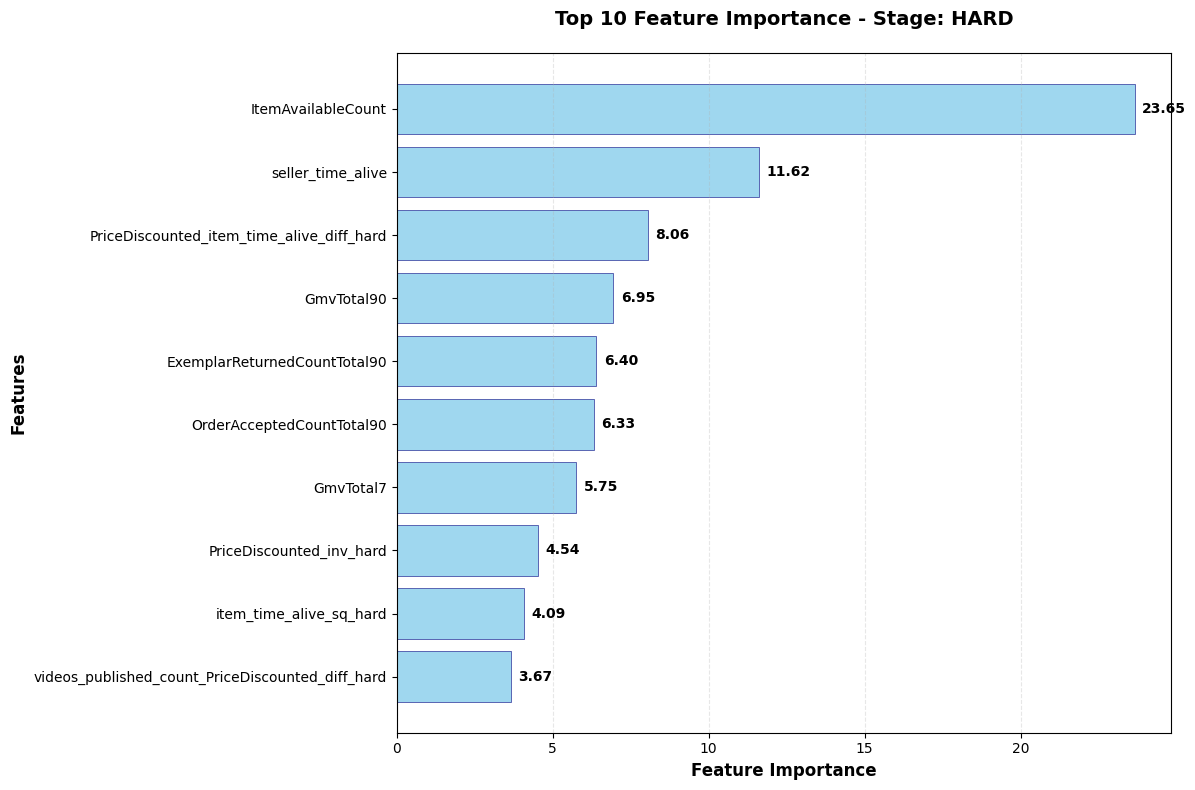

\n=== TOP 10 FEATURES FOR STAGE HARD ===
 1. ItemAvailableCount                        23.6532
 2. seller_time_alive                         11.6235
 3. PriceDiscounted_item_time_alive_diff_hard   8.0613
 4. GmvTotal90                                 6.9475
 5. ExemplarReturnedCountTotal90               6.4022
 6. OrderAcceptedCountTotal90                  6.3284
 7. GmvTotal7                                  5.7539
 8. PriceDiscounted_inv_hard                   4.5435
 9. item_time_alive_sq_hard                    4.0899
10. videos_published_count_PriceDiscounted_diff_hard   3.6652


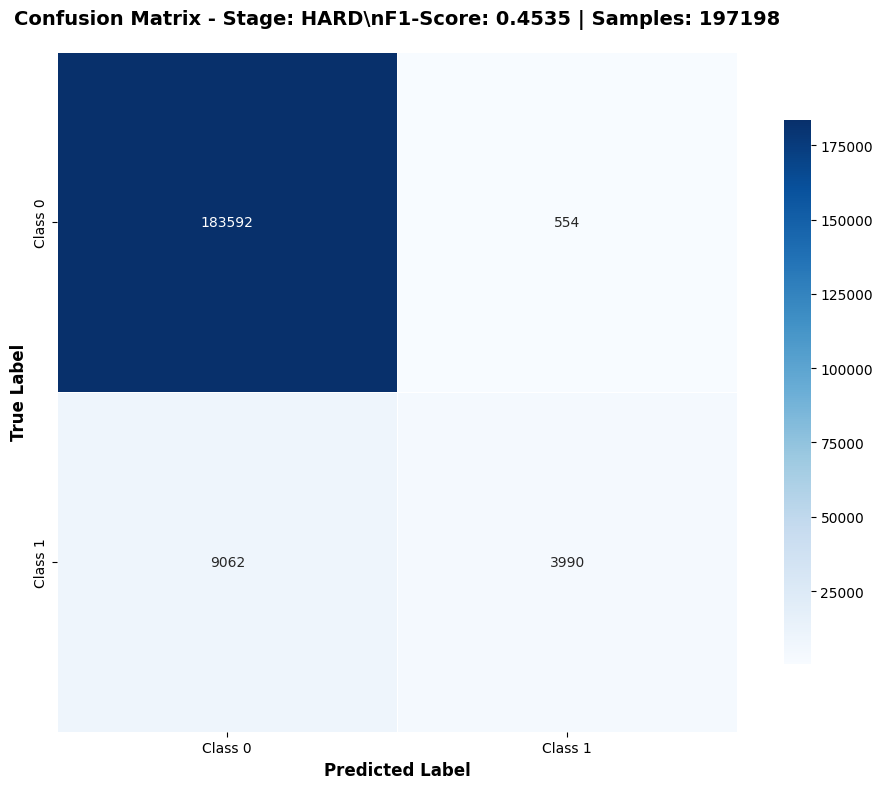

\n=== CONFUSION MATRIX ANALYSIS - STAGE HARD ===
Total samples: 197198
True Negatives (TN): 183592
False Positives (FP): 554
False Negatives (FN): 9062
True Positives (TP): 3990
Precision: 0.8781
Recall: 0.3057
F1-Score: 0.4535
Accuracy: 0.9512


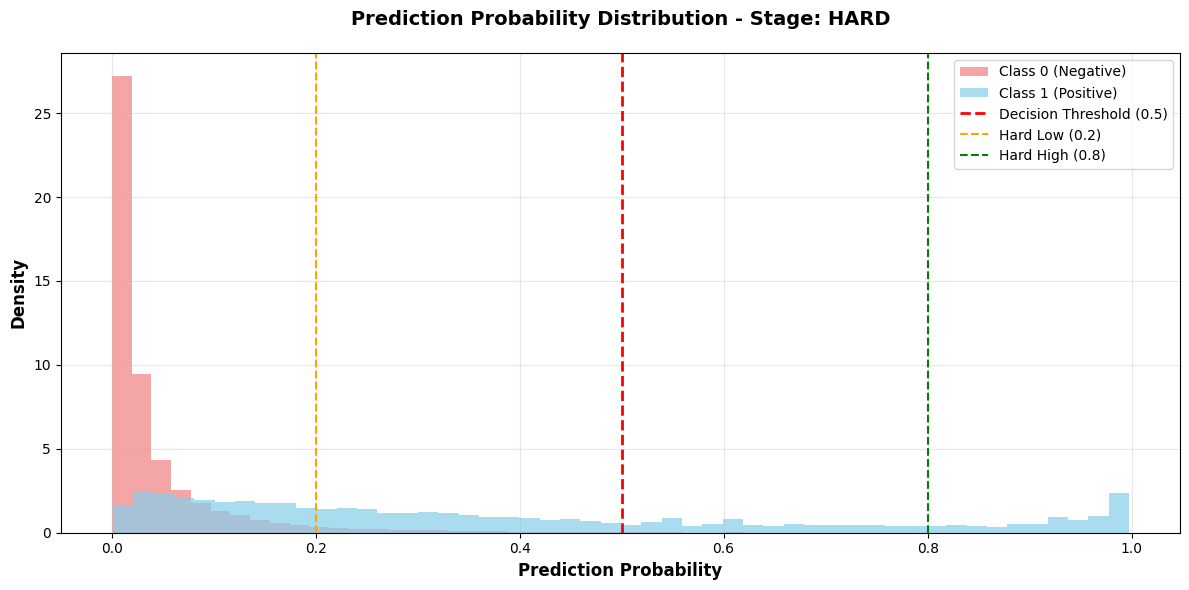

Filtering confident predictions for hard...
Confident: 178649, Remaining: 18549

Stage: soft, Sample size: 18549
STAGE: SOFT
Sample size: 18549
Feature engineeringsoft...
Continuous: 28, Categorical: 9
Applying 205 expressions in batches of 25
Memory: 1.67 GB
Memory: 1.65 GB
Memory: 1.66 GB
Memory: 1.66 GB
Memory: 1.66 GB
Memory: 1.67 GB
Memory: 1.67 GB
Memory: 1.67 GB
Memory: 1.67 GB
Generated 205 new features for soft
Removing duplicates for soft...
Removed identical: rating_1_count_medianlag_soft (same as rating_1_count_q75flag_soft)
Removed identical: rating_5_count_q25flag_soft (same as rating_1_count_q25flag_soft)
Removed identical: comments_published_count_q25flag_soft (same as rating_1_count_q25flag_soft)
Removed identical: photos_published_count_q25flag_soft (same as rating_1_count_q25flag_soft)
Removed identical: item_count_sales7_q25flag_soft (same as rating_1_count_q25flag_soft)
Removed identical: item_count_sales30_q25flag_soft (same as rating_1_count_q25flag_soft)
Removed

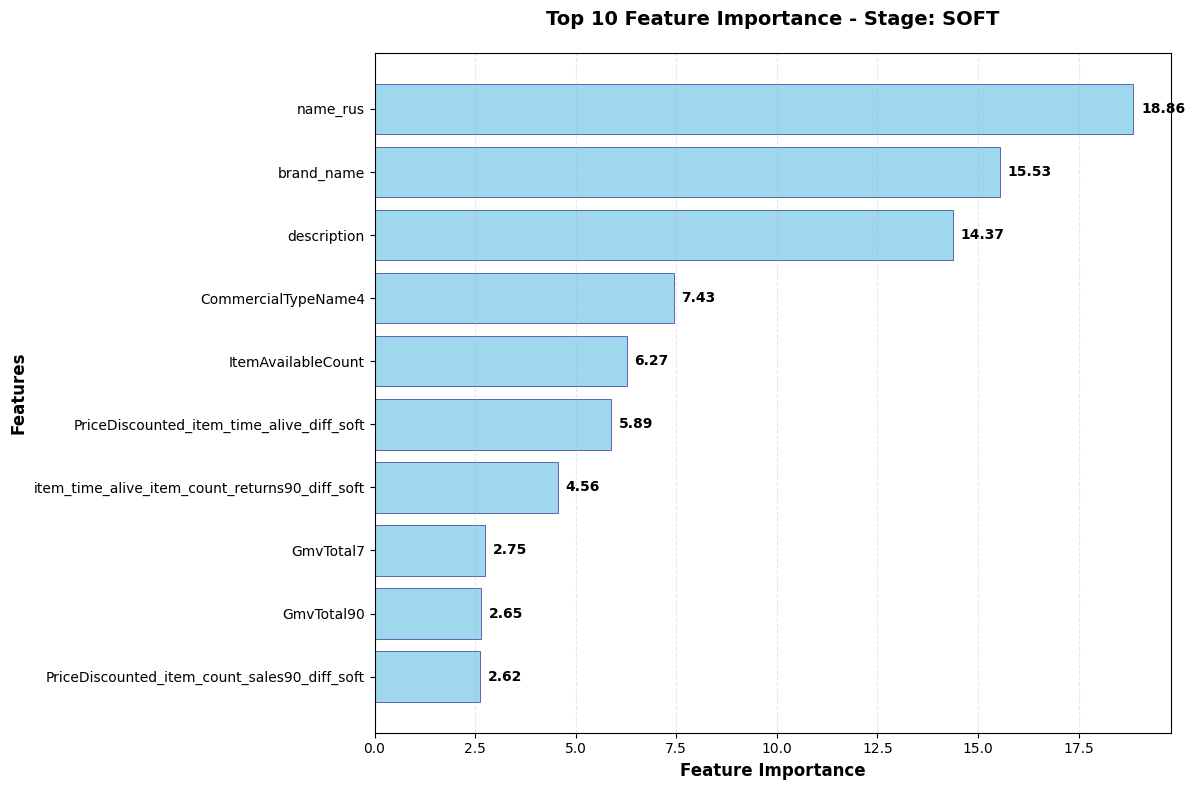

\n=== TOP 10 FEATURES FOR STAGE SOFT ===
 1. name_rus                                  18.8599
 2. brand_name                                15.5348
 3. description                               14.3748
 4. CommercialTypeName4                        7.4315
 5. ItemAvailableCount                         6.2736
 6. PriceDiscounted_item_time_alive_diff_soft   5.8852
 7. item_time_alive_item_count_returns90_diff_soft   4.5560
 8. GmvTotal7                                  2.7477
 9. GmvTotal90                                 2.6489
10. PriceDiscounted_item_count_sales90_diff_soft   2.6167


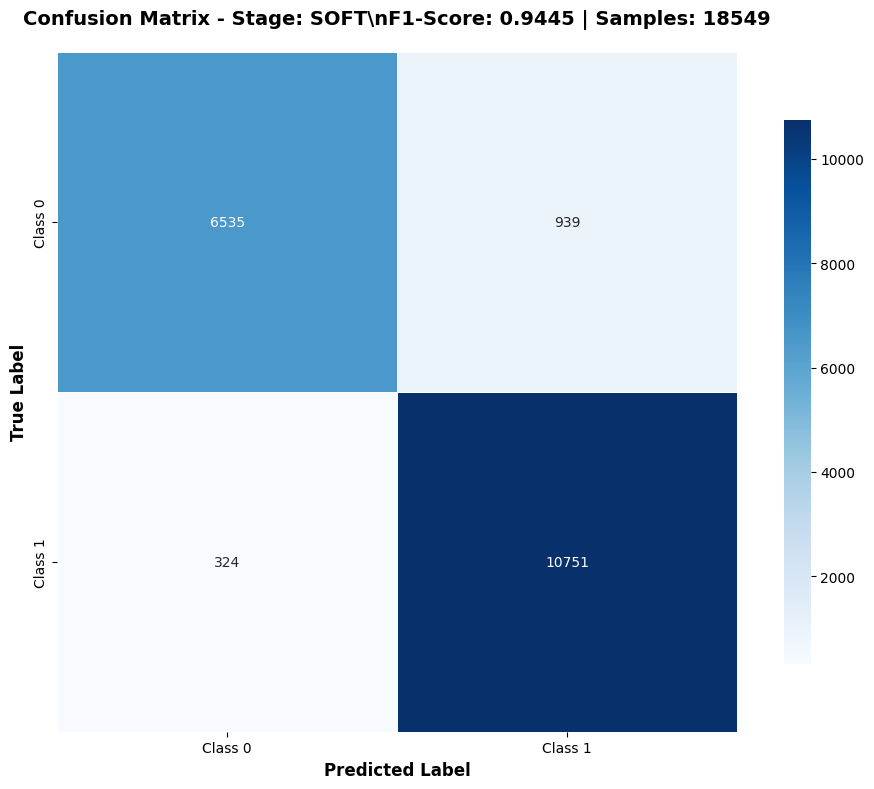

\n=== CONFUSION MATRIX ANALYSIS - STAGE SOFT ===
Total samples: 18549
True Negatives (TN): 6535
False Positives (FP): 939
False Negatives (FN): 324
True Positives (TP): 10751
Precision: 0.9197
Recall: 0.9707
F1-Score: 0.9445
Accuracy: 0.9319


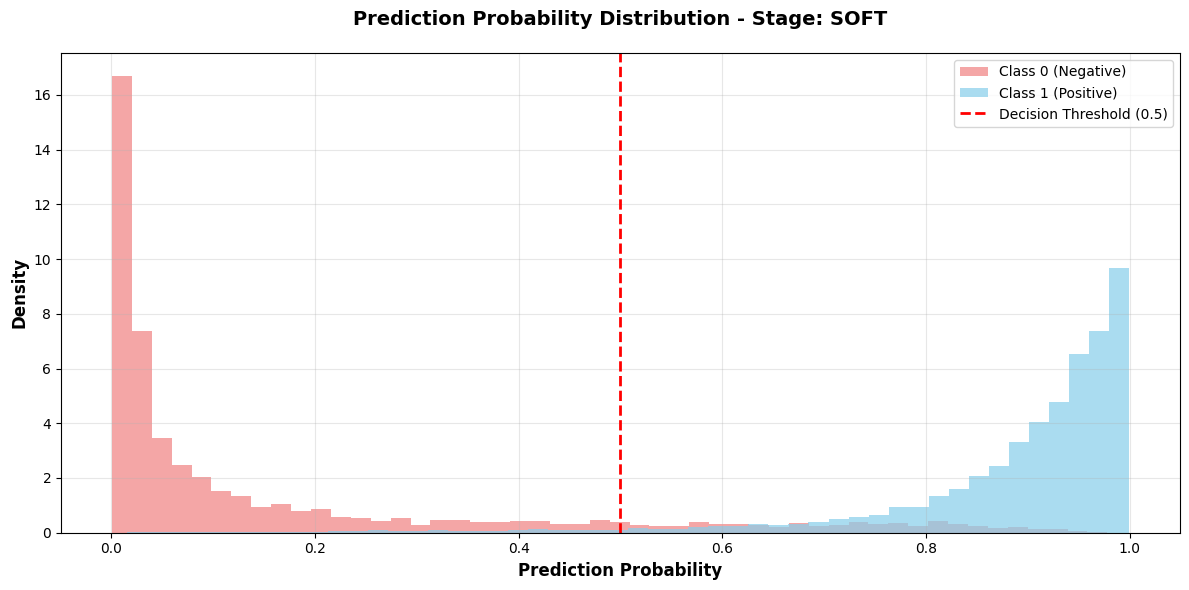

Filtering confident predictions for soft...
Confident: 14954, Remaining: 3595

Stage: error, Sample size: 3595
STAGE: ERROR
Sample size: 3595
Feature engineeringerror...
Continuous: 22, Categorical: 15
Applying 205 expressions in batches of 25
Memory: 1.58 GB
Memory: 1.58 GB
Memory: 1.58 GB
Memory: 1.58 GB
Memory: 1.58 GB
Memory: 1.58 GB
Memory: 1.58 GB
Memory: 1.59 GB
Memory: 1.59 GB
Generated 205 new features for error
Removing duplicates for error...
Removed identical: rating_5_count_medianlag_error (same as rating_5_count_q75flag_error)
Removed identical: comments_published_count_q25flag_error (same as rating_5_count_q25flag_error)
Removed identical: item_count_sales30_q25flag_error (same as rating_5_count_q25flag_error)
Removed identical: item_count_sales90_q25flag_error (same as rating_5_count_q25flag_error)
Removed identical: comments_published_count_medianlag_error (same as comments_published_count_q75flag_error)
Removed identical: item_count_sales30_medianlag_error (same as it

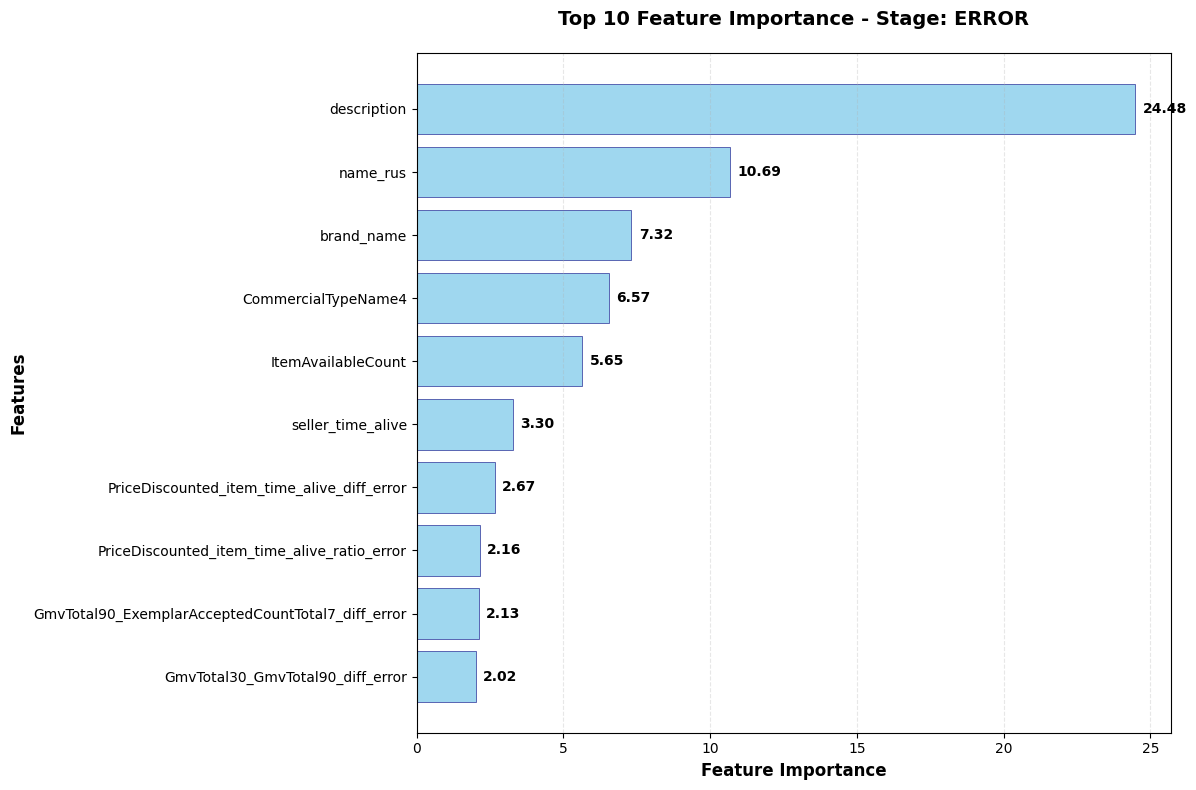

\n=== TOP 10 FEATURES FOR STAGE ERROR ===
 1. description                               24.4844
 2. name_rus                                  10.6867
 3. brand_name                                 7.3200
 4. CommercialTypeName4                        6.5680
 5. ItemAvailableCount                         5.6492
 6. seller_time_alive                          3.2975
 7. PriceDiscounted_item_time_alive_diff_error   2.6706
 8. PriceDiscounted_item_time_alive_ratio_error   2.1552
 9. GmvTotal90_ExemplarAcceptedCountTotal7_diff_error   2.1281
10. GmvTotal30_GmvTotal90_diff_error           2.0178


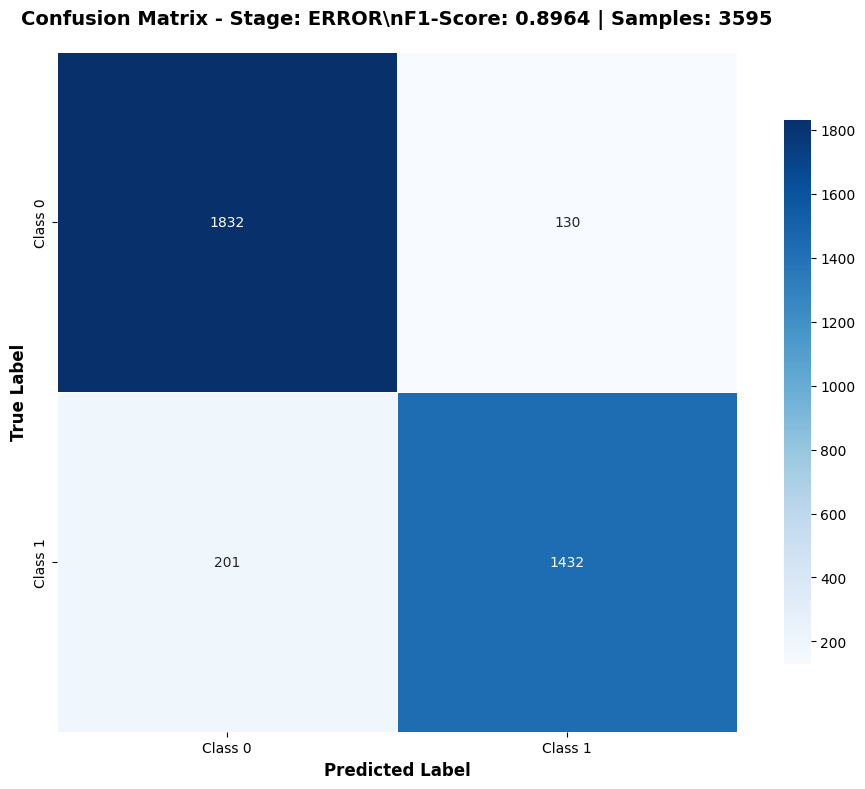

\n=== CONFUSION MATRIX ANALYSIS - STAGE ERROR ===
Total samples: 3595
True Negatives (TN): 1832
False Positives (FP): 130
False Negatives (FN): 201
True Positives (TP): 1432
Precision: 0.9168
Recall: 0.8769
F1-Score: 0.8964
Accuracy: 0.9079


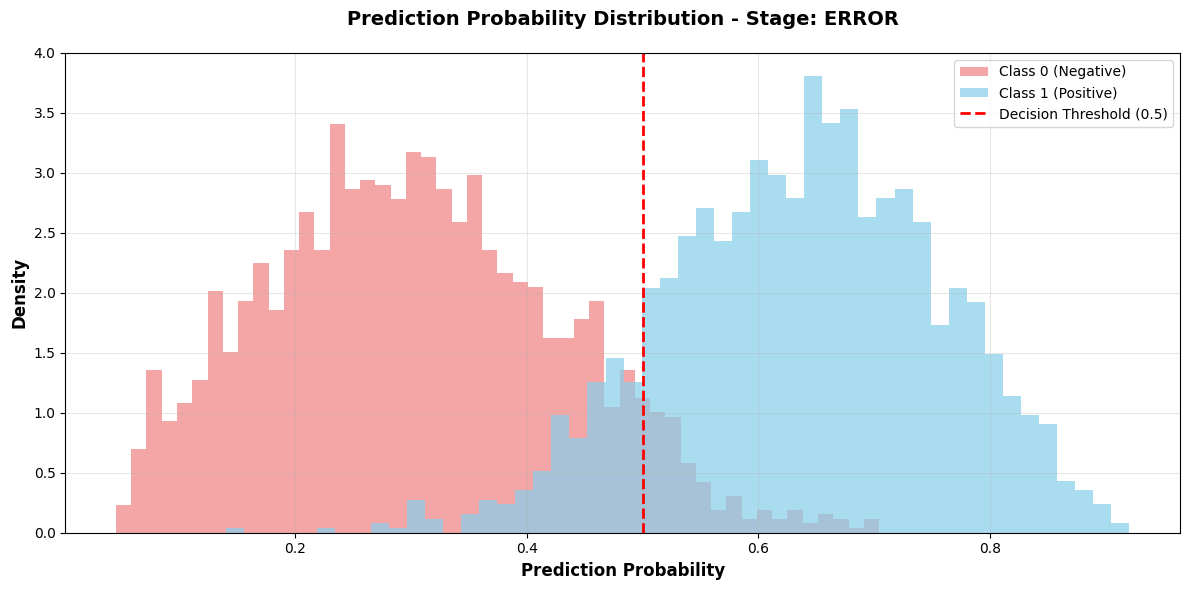

Filtering confident predictions for error...
Confident: 571, Remaining: 3024
\n================================================================================
FINAL PIPELINE SUMMARY
Stage  Features  Best F1  Iterations
 HARD        20 0.451128         200
 SOFT        34 0.944129         293
ERROR        49 0.897338         226


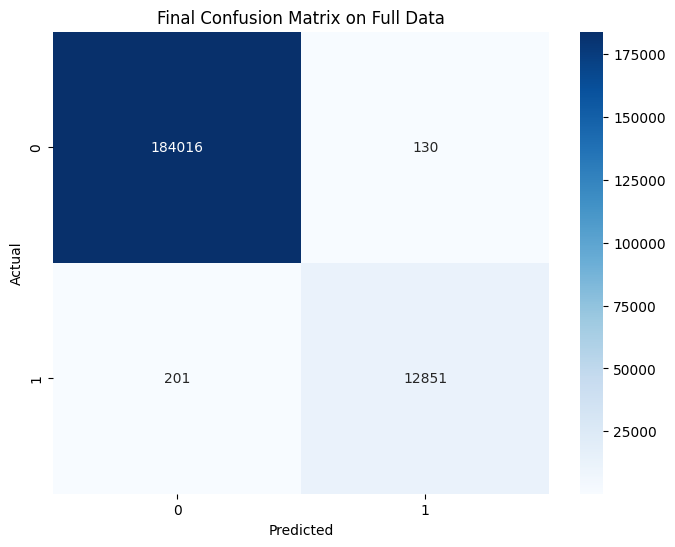

Confusion Matrix:
 [[184016    130]
 [   201  12851]]
Total metrics:

Precision: 0.9900
Recall: 0.9846
F1-Score: 0.9873
Accuracy: 0.9983
PIPELINE COMPLETED!

PREDICTION PHASE
Test size: 31391
STARTING CASCADE PREDICTION

Predicting stage: hard, samples: 31391
Preparing test features for hard...
Feature engineeringhard...
Continuous: 33, Categorical: 4
Applying 185 expressions in batches of 25
Memory: 1.62 GB
Memory: 1.63 GB
Memory: 1.63 GB
Memory: 1.63 GB
Memory: 1.64 GB
Memory: 1.65 GB
Memory: 1.65 GB
Memory: 1.66 GB
Generated 185 new features for hard
Removing duplicates for hard...
Removed identical: rating_1_count_medianlag_hard (same as rating_1_count_q75flag_hard)
Removed identical: rating_3_count_q25flag_hard (same as rating_1_count_q25flag_hard)
Removed identical: rating_4_count_q25flag_hard (same as rating_1_count_q25flag_hard)
Removed identical: rating_5_count_q25flag_hard (same as rating_1_count_q25flag_hard)
Removed identical: comments_published_count_q25flag_hard (same as 

In [11]:
def full_pipeline_with_prediction(train_path, test_path, output_dir="./"):
    """Полный pipeline: обучение + предсказание + сохранение"""
    print("FULL PIPELINE: TRAIN + PREDICT + SAVE")
    print("="*80)
    
    try:
        # 1. Загрузка данных
        print("Loading data...")
        train_df = pl.read_csv(train_path)
       
        
        print(f"Train size: {len(train_df)}")
        
        
        # 2. Обучение моделей
        print("\n" + "="*80)
        print("TRAINING PHASE")
        print("="*80)
        #train_df = train_df.sample(10000)
        trained_models, selected_features = main_pipeline(train_df)
        
        
        
        if not trained_models:
            raise Exception("No models were trained successfully!")
        
        # 3. Идентификация текстовых колонок
        text_columns = [col for col, dtype in train_df.schema.items() 
                       if dtype == pl.String and col not in col_drop + [target]]
        
        # 4. Предсказание на тестовых данных
        print("\n" + "="*80)
        print("PREDICTION PHASE")
        print("="*80)


        app_test = 'ml_ozon_сounterfeit_new_test.csv'
        df_test_old = pl.read_csv(test_path)
        df_test_append = pl.read_csv(app_test)
    
        test_df = df_test_old.vstack(df_test_append)
        print(f"Test size: {len(test_df)}")
        
        # Восстанавливаем used_features_across_stages из обученных моделей
        used_features_global = set()
        for stage_features in selected_features.values():
            used_features_global.update(stage_features)
        
        results_df = cascade_predict(test_df, trained_models, selected_features, text_columns, used_features_global)
        
        # 5. Сохранение результатов
        print("\n" + "="*80)
        print("SAVING RESULTS")
        print("="*80)
        
        import os
        output_path = os.path.join(output_dir, "predictions.csv")
        detailed_path = os.path.join(output_dir, "detailed_predictions.csv")
        
        saved_files = save_predictions(results_df, output_path, detailed_path)
        
        print("="*80)
        print("FULL PIPELINE COMPLETED SUCCESSFULLY!")
        print(f"Results saved to: {saved_files}")
        print("="*80)
        
        return trained_models, selected_features, results_df
        
    except Exception as e:
        print(f"Pipeline failed: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None


if __name__ == "__main__":
    # Пути к файлам
    train_path = 'OZON/ml_ozon_сounterfeit_data/ml_ozon_сounterfeit_train.csv' # Укажите путь к тренировочным данным
    test_path = 'OZON/ml_ozon_сounterfeit_data/ml_ozon_сounterfeit_test.csv'    # Укажите путь к тестовым данным
    output_dir = "./"
    
    # Запуск полного pipeline
    models, features, predictions = full_pipeline_with_prediction(train_path, test_path, output_dir)
    
    if predictions is not None:
        print("Pipeline completed successfully!")
        print(f"Generated predictions for {len(predictions)} samples")
    else:
        print("Pipeline failed!")